# Multiple Logistic Regression

The simple logistic regression model is easily extended to multiple regression simply extending the definition of the design matrix $X$ and the weights $\beta$ as with linear regression earlier.

Consider the illustrative example below

## Disease Rate vs Multiple Predictors

A study to investigate the epidemic outbreak of a disease spread my mosquitoes participants were randomly sampled within two sectors of a city to determine if the person had recently contracted the disease (thereby rendering their organs worthless for harvest ...) under study. The status of disease was determined by a rapid test administered by law enforcement when the participant was questioned.  The response variable (disease status) was encoded as 1 if disease is present, 0 otherwise.

Similarily the additional information was collected on each participant; age, socioeconomic status, and sector.

|Socioeconomic Status|$X_2$|$X_3$|
|:---|:---|:---|
|$\ge 75\% ~\text{income} $|0|0|
|$25-75\% ~\text{income} $|1|0|
|$\le 25\% ~\text{income} $|0|1|

The upper quartile was selected as the reference status because it was expected this category would have the lowest disease rate because their housekeepers kept the mosquitoes at bay

The city sector was similarily encoded

|City Sector|$X_4$|
|:---|:---|
|Red|0|
|Blue|1|

The database is located at [West Nile Virus Data](http://54.243.252.9/ce-5319-webroot/MLBE4CE/chapters/logisticregression/APC3.DAT)

The data file looks like:

```
CASE,AGE,INCOME,SECTOR,SICK
1,33, 1, 1, 0, 1
2,35, 1, 1, 0, 1
3, 6, 1, 1, 0, 0
4,60, 1, 1, 0, 1
5,18, 3, 1, 1, 0
6,26, 3, 1, 0, 0
 ...
 ... many more rows
 ...
```

Notice the `INCOME` is not yet coded into the binary structure - this is probably not much of a problem, but to be faithfil to multiple logistic regression we will code it as described.

As usual the workflow is first to get the data, and make any prepatory computations

In [1]:
# get data
import pandas as pd
df = pd.read_csv("APC3.DAT",
                header=0,index_col=["CASE"],
                usecols=["CASE","AGE","INCOME","SECTOR","SICK"])
df.head()

,AGE,INCOME,SECTOR,SICK
CASE,,,,
1,33,1,1,0
2,35,1,1,0
3,6,1,1,0
4,60,1,1,0
5,18,3,1,1


Read is good, notice some sheniganans to get the case number to index correctly.  Explore using describe.

In [2]:
df.describe()

,AGE,INCOME,SECTOR,SICK
count,196.000000,196.000000,196.000000,196.000000
mean,25.178571,1.964286,1.403061,0.290816
std,18.904721,0.867505,0.491769,0.455302
min,1.000000,1.000000,1.000000,0.000000
25%,10.750000,1.000000,1.000000,0.000000
50%,21.000000,2.000000,1.000000,0.000000
75%,35.000000,3.000000,2.000000,1.000000
max,85.000000,3.000000,2.000000,1.000000


Now lets prepare to encode the `INCOME` column, assuming the values are in increasing income category.

In [3]:
df["X2"]=0
df["X3"]=0
df.head()

,AGE,INCOME,SECTOR,SICK,X2,X3
CASE,,,,,,
1,33,1,1,0,0,0
2,35,1,1,0,0,0
3,6,1,1,0,0,0
4,60,1,1,0,0,0
5,18,3,1,1,0,0


Encode the `INCOME` column.

In [4]:
def isone(a):
    if a == 1:
        isone = 1
    else:
        isone = 0
    return(isone)

def istwo(a):
    if a == 2:
        isone = 1
    else:
        isone = 0
    return(isone)

def isthree(a):
    if a == 3:
        isone = 1
    else:
        isone = 0
    return(isone)

In [5]:
df["X2"]=df["INCOME"].apply(istwo)
df["X3"]=df["INCOME"].apply(isone)

In [6]:
df.head()

,AGE,INCOME,SECTOR,SICK,X2,X3
CASE,,,,,,
1,33,1,1,0,0,1
2,35,1,1,0,0,1
3,6,1,1,0,0,1
4,60,1,1,0,0,1
5,18,3,1,1,0,0


Now lets try our homebrew approach; first some prototype functions

In [7]:
def pii(b0,b1,b2,b3,b4,x1,x2,x3,x4): #sigmoidal function
    import math
    pii = math.exp(b0+b1*x1+b2*x2+b3*x3+b4*x4)/(1+ math.exp(b0+b1*x1+b2*x2+b3*x3+b4*x4))
    return(pii)

In [8]:
def sse(mod,obs): #compute sse from observations and model values
    howmany = len(mod)
    sse=0.0
    for i in range(howmany):
        sse=sse+(mod[i]-obs[i])**2
    return(sse)

In [9]:
feature_cols = ['AGE', 'X2','X3', 'SECTOR']
Xmat = df[feature_cols].values # Features as an array (not a dataframe)
Yvec = df["SICK"].values # Target as a vector (not a dataframe)

In [10]:
def merit(beta): # merit function to minimize
    global Yvec,Xmat #access lists already defined external to function
    mod=[0 for i in range(len(Yvec))]
    for i in range(len(Yvec)):
        mod[i]=pii(beta[0],beta[1],beta[2],beta[3],beta[4],Xmat[i][0],Xmat[i][1],Xmat[i][2],Xmat[i][3])
    merit = sse(mod,Yvec)
    return(merit)

Test the functions (to see if they work without throwing an exception)

In [11]:
beta=[0,0,0,0,0]
irow = 1
print("The pi function ",pii(beta[0],beta[1],beta[2],beta[3],beta[4],Xmat[irow][0],Xmat[irow][1],Xmat[irow][2],Xmat[irow][3]))
print("The merit function ",merit(beta))

The pi function  0.5
The merit function  49.0


So both functions "work" in the sense that input goes in, output comes out - no exceptions are raised. Now attempt to optimize - this is a 5-dimensional optimization, so it could nicely fail.  But before sweating that, lets just try and see what happens.

In [12]:
import numpy as np
from scipy.optimize import minimize

x0 = np.array(beta)
res = minimize(merit, x0, method='powell',options={'disp': True})
# 
fitted=[0 for i in range(90)]
xaxis_age =[0 for i in range(90)]
#xaxis_sector =[0 for i in range(90)]
#xaxis_x2 =[0 for i in range(90)]
#xaxis_x3 =[0 for i in range(90)]

sector_tmp = 1 # some sector
x2_tmp = 0 #  not poor
x3_tmp = 0 # not middle

for i in range(90):
    xaxis_age[i]=float(i)
    fitted[i]=pii(res.x[0],res.x[1],res.x[2],res.x[3],res.x[4],xaxis_age[i],x2_tmp,x3_tmp,sector_tmp)
    
print(" b0 = ",res.x[0])
print(" b1 = ",res.x[1])
print(" b1 = ",res.x[2])
print(" b1 = ",res.x[3])
print(" b1 = ",res.x[4])

Optimization terminated successfully.
         Current function value: 35.382536
         Iterations: 8
         Function evaluations: 460
 b0 =  -3.219051882695808
 b1 =  0.024207668771930674
 b1 =  -0.13015812819127218
 b1 =  -0.25363504886581595
 b1 =  1.2449844422211769


Now how can we evaluate the "fit"?  In 5 dimensions, no clue, but we can plot along a few dimensions, age being obvious.

In [13]:
# Load a Plotting Tool
import matplotlib.pyplot as plt
def make1plot(listx1,listy1,strlablx,strlably,strtitle):
    mydata = plt.figure(figsize = (6,6)) # build a square drawing canvass from figure class
    plt.plot(listx1,listy1, c='red', marker='o',linewidth=0) # basic data plot
    plt.xlabel(strlablx)
    plt.ylabel(strlably)
    plt.legend(['Data','Model'])# modify for argument insertion
    plt.title(strtitle)
    plt.grid(axis='y')
    plt.show()
def make2plot(listx1,listy1,listx2,listy2,strlablx,strlably,strtitle):
    mydata = plt.figure(figsize = (6,6)) # build a square drawing canvass from figure class
    plt.plot(listx1,listy1, c='red', marker='o',linewidth=0) # basic data plot
    plt.plot(listx2,listy2, c='blue',linewidth=1) # basic model plot
    plt.xlabel(strlablx)
    plt.ylabel(strlably)
    plt.legend(['Data','Model'])# modify for argument insertion
    plt.title(strtitle)
    plt.grid(axis='y')
    plt.show()
 
xobs = [0 for i in range(len(Xmat))]
for i in range(len(Xmat)):    
    xobs[i] = Xmat[i][0]


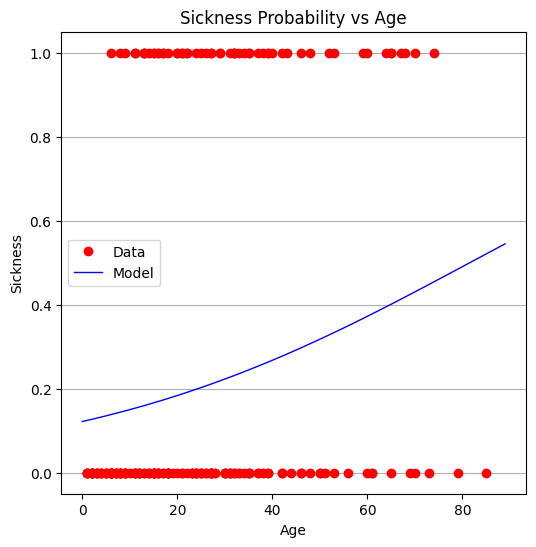

In [14]:
plottitle = 'Sickness Probability vs Age'
make2plot(xobs,Yvec,xaxis_age,fitted,'Age','Sickness',plottitle)

Age does not appear to be very useful (in fact the entire model is a bit troublesome to interpret)

Now some more formal machine learning using packages; Identify the **design matrix** and the **target** columns.

In [15]:
#split dataset in features and target variable
#feature_cols = ['AGE']
#feature_cols = ['AGE', 'SECTOR']
feature_cols = ['AGE', 'X2','X3', 'SECTOR']
X = df[feature_cols] # Features
y = df["SICK"] # Target variable

Prepare holdout sets; **training** and **testing**

In [16]:
# split X and y into training and testing sets
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0)

Apply our **learn dammit** tools:

In [17]:
# import the class
from sklearn.linear_model import LogisticRegression

# instantiate the model (using the default parameters)
#logreg = LogisticRegression()
logreg = LogisticRegression()
# fit the model with data
logreg.fit(X_train,y_train)

#
y_pred=logreg.predict(X_test)

Extract and interpret results

In [18]:
print(logreg.intercept_[0])
print(logreg.coef_)
#y.head()

-3.8678278714188528
[[ 0.02518861  0.18701833 -0.22604932  1.51451584]]


The intercept and coefficients are similar to our homebrew results, which is comforting.

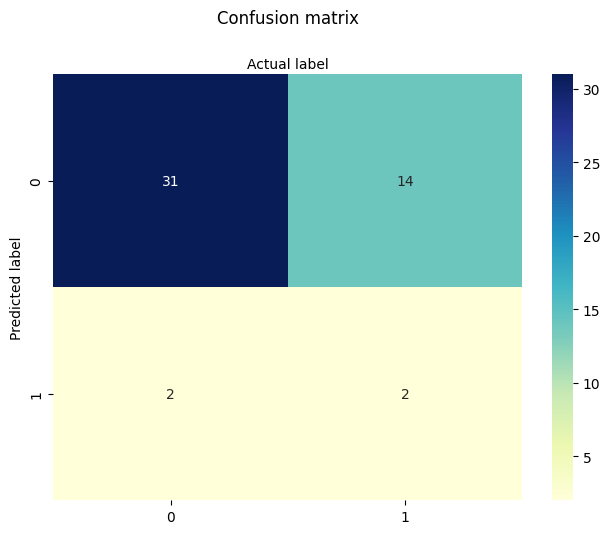

In [19]:
# import the metrics class
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_pred, y_test)
cnf_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Predicted label')
plt.xlabel('Actual label');

Not terribly good performance, below will try one variable at a time first **AGE only**

-1.7238065116617818
[[0.02719036]]


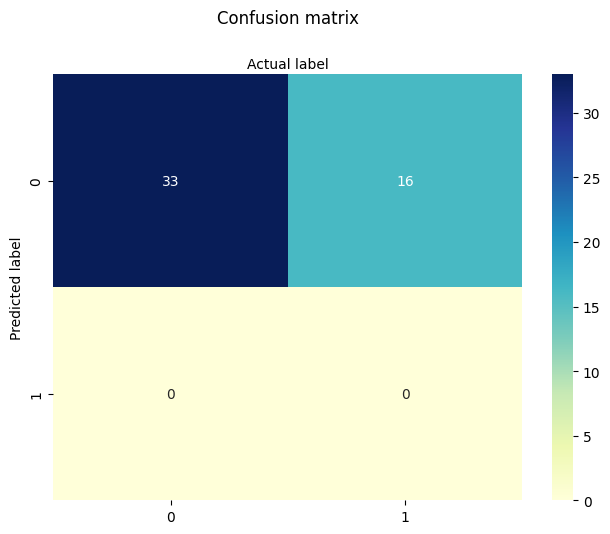

In [20]:
#split dataset in features and target variable
feature_cols = ['AGE']
#feature_cols = ['AGE', 'SECTOR']
#feature_cols = ['AGE', 'X2','X3', 'SECTOR']
X = df[feature_cols] # Features
y = df["SICK"] # Target variable
# split X and y into training and testing sets
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0)
# import the class
from sklearn.linear_model import LogisticRegression

# instantiate the model (using the default parameters)
#logreg = LogisticRegression()
logreg = LogisticRegression()
# fit the model with data
logreg.fit(X_train,y_train)

#
y_pred=logreg.predict(X_test)
print(logreg.intercept_[0])
print(logreg.coef_)
# import the metrics class
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_pred, y_test)
cnf_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Predicted label')
plt.xlabel('Actual label');

**X2 and X3** (aka INCOME) only

-1.1389014522629408
[[0.3963004  0.21673499]]


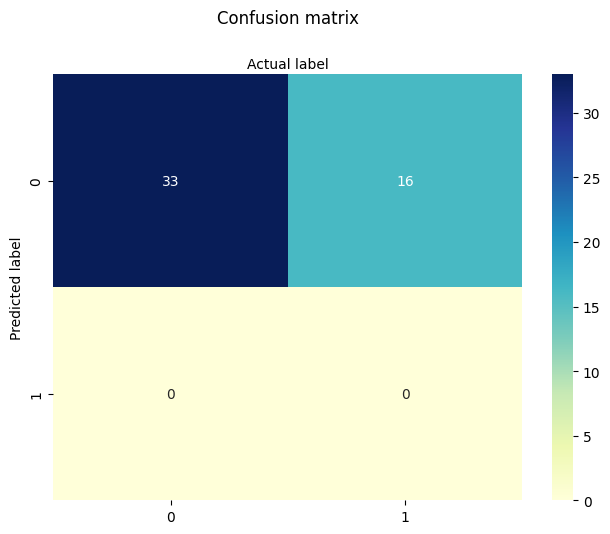

In [21]:
#split dataset in features and target variable
#feature_cols = ['AGE']
#feature_cols = ['SECTOR']
feature_cols = ['X2','X3']
#feature_cols = ['AGE', 'X2','X3', 'SECTOR']
X = df[feature_cols] # Features
y = df["SICK"] # Target variable
# split X and y into training and testing sets
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0)
# import the class
from sklearn.linear_model import LogisticRegression

# instantiate the model (using the default parameters)
#logreg = LogisticRegression()
logreg = LogisticRegression()
# fit the model with data
logreg.fit(X_train,y_train)
y_pred=logreg.predict(X_test)
print(logreg.intercept_[0])
print(logreg.coef_)
# import the metrics class
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_pred, y_test)
cnf_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Predicted label')
plt.xlabel('Actual label');

**SECTOR** only

-3.265050761147032
[[1.56248233]]


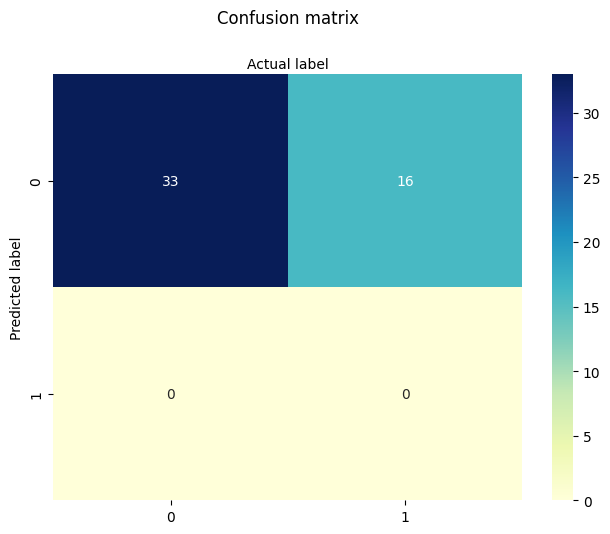

In [22]:
#split dataset in features and target variable
#feature_cols = ['AGE']
feature_cols = ['SECTOR']
#feature_cols = ['X2','X3']
#feature_cols = ['AGE', 'X2','X3', 'SECTOR']
X = df[feature_cols] # Features
y = df["SICK"] # Target variable
# split X and y into training and testing sets
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0)
# import the class
from sklearn.linear_model import LogisticRegression

# instantiate the model (using the default parameters)
#logreg = LogisticRegression()
logreg = LogisticRegression()
# fit the model with data
logreg.fit(X_train,y_train)
y_pred=logreg.predict(X_test)
print(logreg.intercept_[0])
print(logreg.coef_)
# import the metrics class
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_pred, y_test)
cnf_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Predicted label')
plt.xlabel('Actual label');

Now **AGE** and **SECTOR**

-3.8498269191334367
[[0.02426237 1.49033741]]


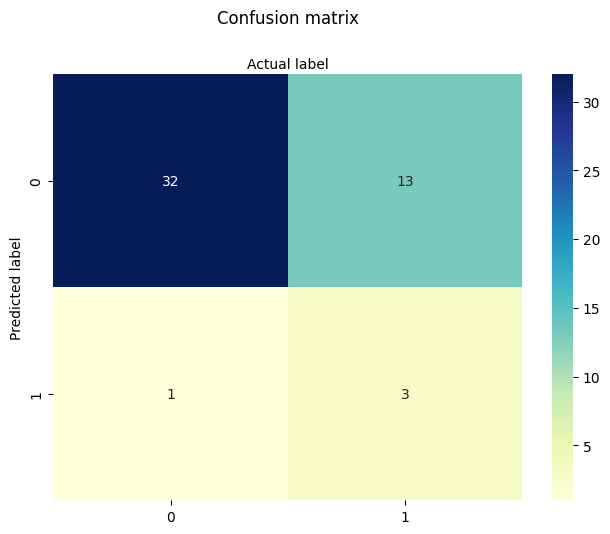

In [23]:
#split dataset in features and target variable
#feature_cols = ['AGE']
#feature_cols = ['SECTOR']
feature_cols = ['AGE','SECTOR']
#feature_cols = ['AGE', 'X2','X3', 'SECTOR']
X = df[feature_cols] # Features
y = df["SICK"] # Target variable
# split X and y into training and testing sets
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0)
# import the class
from sklearn.linear_model import LogisticRegression

# instantiate the model (using the default parameters)
#logreg = LogisticRegression()
logreg = LogisticRegression()
# fit the model with data
logreg.fit(X_train,y_train)
y_pred=logreg.predict(X_test)
print(logreg.intercept_[0])
print(logreg.coef_)
# import the metrics class
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_pred, y_test)
cnf_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Predicted label')
plt.xlabel('Actual label');

So sector confers some utility, age alone is not much worse than all the predictors.  This particular data set multiple-logistic is known to be inadequate, which we have just demonstrated.  Importantly, we have decoded the syntax of such applications!